In [1]:
# Set random seed to ensure reproducible results
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.metrics import accuracy_score
import warnings
from tensorflow import keras
from tensorflow.keras import layers
from prettytable import PrettyTable


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
players = pd.read_csv('./data/male_players.csv', sep=',', quotechar='"', encoding='utf-8')

fifa_versions = range(15, 25) 

# Initialize an empty dictionary to store DataFrames
players_by_version = {}

# Loop through each FIFA version and filter the DataFrame
for version in fifa_versions:
    version_df = players[players['fifa_version'] == version].reset_index(drop=True)
    version_df = version_df.drop(columns=['fifa_version', 'fifa_update', 'update_as_of'])
    players_by_version[f'players_{version}'] = version_df
    print(f"Created DataFrame for FIFA {version} with {len(version_df)} records.")


Created DataFrame for FIFA 15 with 16182 records.
Created DataFrame for FIFA 16 with 16706 records.
Created DataFrame for FIFA 17 with 17596 records.
Created DataFrame for FIFA 18 with 17954 records.
Created DataFrame for FIFA 19 with 18086 records.
Created DataFrame for FIFA 20 with 18483 records.
Created DataFrame for FIFA 21 with 18892 records.
Created DataFrame for FIFA 22 with 19239 records.
Created DataFrame for FIFA 23 with 18533 records.
Created DataFrame for FIFA 24 with 18350 records.


## 1. Data Preparation
- Processing both FIFA 23 and FIFA 24 datasets simultaneously but will only use FIFA 23 for training

In [3]:
players_24 = players_by_version['players_24']
players_23 = players_by_version['players_23']

players_23.shape, players_24.shape

((18533, 106), (18350, 106))

In [4]:
# List all columns of fifa 23 player dataset
print(f'Are the columns in the 2 datasets same? {set(players_23.columns) == set(players_24.columns)}\n')
print('All column names:\n')
print(list(players_23.columns))

Are the columns in the 2 datasets same? True

All column names:

['player_id', 'player_url', 'short_name', 'long_name', 'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob', 'height_cm', 'weight_kg', 'club_team_id', 'club_name', 'league_id', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_loaned_from', 'club_joined_date', 'club_contract_valid_until_year', 'nationality_id', 'nationality_name', 'nation_team_id', 'nation_position', 'nation_jersey_number', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'move

In [5]:
# See the first 5 rows of the dataset
players_23.head()

,player_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/230002,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,95,190500000.0,230000.0,23,1998-12-20,182,73,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,ST,7.0,NaN,2018-07-01,2024.0,18,France,1335.0,LS,10.0,Right,4,5,4,High/Low,Unique,Yes,366700000.0,"#Speedster, #Dribbler, #Acrobat, #Clinical Fin...","Solid Player, Flair, Speed Dribbler (AI), Outs...",97.0,89.0,80.0,92.0,36.0,76.0,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88.0,26,34,32,13,5,7,11,6,NaN,89+3,89+3,89+3,90,90,90,90,90,89+3,89+3,89+3,89+3,81+3,81+3,81+3,89+3,67+3,63+3,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3
1,158023,/player/158023/lionel-messi/230002,L. Messi,Lionel Andrés Messi Cuccittini,RW,91,91,54000000.0,195000.0,35,1987-06-24,169,67,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Low/Low,Unique,Yes,99900000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96.0,20,35,24,6,11,15,14,8,NaN,87+3,87+3,87+3,90,91,91,91,90,92-1,92-1,92-1,89+2,85+3,85+3,85+3,89+2,64+3,63+3,63+3,63+3,64+3,59+3,50+3,50+3,50+3,59+3,19+3
2,165153,/player/165153/karim-benzema/230002,K. Benzema,Karim Benzema,"CF, ST",91,91,64000000.0,450000.0,34,1987-12-19,185,81,243.0,Real Madrid,53.0,La Liga,1.0,CF,9.0,NaN,2009-07-09,2023.0,18,France,1335.0,RS,19.0,Right,4,4,4,Medium/Medium,Normal (170-185),Yes,131200000.0,"#Poacher, #Clinical Finisher","Leadership, Finesse Shot, Playmaker (AI), Outs...",80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90.0,43,24,18,13,11,5,5,7,NaN,89+2,89+2,89+2,87,89,89,89,87,88+3,88+3,88+3,86+3,81+3,81+3,81+3,86+3,64+3,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
3,188545,/player/188545/robert-lewandowski/230002,R. Lewandowski,Robert Lewandowski,ST,91,91,84000000.0,420000.0,33,1988-08-21,185,81,241.0,FC Barcelona,53.0,La Liga,1.0,ST,9.0,NaN,2022-07-18,2025.0,37,Poland,1353.0,ST,9.0,Right,4,4,5,High/Medium,Unique,Yes,172200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",75.0,91.0,79.0,86.0,44.0,83.0,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88.0,35,42,19,15,6,12,8,10,NaN,89+2,89+2,89+2,85,88,88,88,85,85+3,85+3,85+3,83+3,80+3,80+3,80+3,83+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3
4,192985,/player/192985/kevin-de-bruyne/230002,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,107500000.0,350000.0,31,1991-06-28,181,70,1

In [6]:
# Remove useless columns from the data
remove_columns = ['player_url', 'dob', 'real_face', 'long_name', 'body_type', 'club_jersey_number', 'nation_jersey_number']
fifa_23 = players_23.drop(remove_columns, axis=1)
fifa_24 = players_24.drop(remove_columns, axis=1)
fifa_23.shape, fifa_24.shape

((18533, 99), (18350, 99))

In [7]:
# Find columnwise percentage of missing values

total_records = len(fifa_23)
i = 0
col_missing = {}

for col in list(fifa_23.columns):
    missing_values = fifa_23[col].isnull().sum()
    if missing_values > 0:
        col_missing[col] = round((missing_values/total_records) * 100, 2)
        
print(f'Columnwise percentage of missing values:')
for col, perc in sorted(col_missing.items(), key=lambda item : item[1], reverse=True):
    i = i + 1
    print(f'{i}){col} : {perc}%')

Columnwise percentage of missing values:
1)nation_team_id : 95.66%
2)nation_position : 95.66%
3)club_loaned_from : 93.32%
4)player_tags : 92.95%
5)goalkeeping_speed : 88.85%
6)player_traits : 48.08%
7)pace : 11.15%
8)shooting : 11.15%
9)passing : 11.15%
10)dribbling : 11.15%
11)defending : 11.15%
12)physic : 11.15%
13)release_clause_eur : 7.16%
14)club_joined_date : 7.1%
15)value_eur : 0.48%
16)wage_eur : 0.42%
17)club_team_id : 0.42%
18)club_name : 0.42%
19)league_id : 0.42%
20)league_name : 0.42%
21)league_level : 0.42%
22)club_position : 0.42%
23)club_contract_valid_until_year : 0.42%


In [8]:
# Find columnwise percentage of missing values

total_records = len(fifa_24)
i = 0
col_missing = {}

for col in list(fifa_24.columns):
    missing_values = fifa_24[col].isnull().sum()
    if missing_values > 0:
        col_missing[col] = round((missing_values/total_records) * 100, 2)
        
print(f'Columnwise percentage of missing values:')
for col, perc in sorted(col_missing.items(), key=lambda item : item[1], reverse=True):
    i = i + 1
    print(f'{i}){col} : {perc}%')

Columnwise percentage of missing values:
1)nation_team_id : 95.75%
2)nation_position : 95.75%
3)club_loaned_from : 93.57%
4)player_tags : 93.18%
5)goalkeeping_speed : 88.86%
6)player_traits : 53.08%
7)pace : 11.14%
8)shooting : 11.14%
9)passing : 11.14%
10)dribbling : 11.14%
11)defending : 11.14%
12)physic : 11.14%
13)release_clause_eur : 6.98%
14)club_joined_date : 6.9%
15)value_eur : 0.54%
16)wage_eur : 0.47%
17)club_team_id : 0.47%
18)club_name : 0.47%
19)league_id : 0.47%
20)league_name : 0.47%
21)league_level : 0.47%
22)club_position : 0.47%
23)club_contract_valid_until_year : 0.47%


### 1.3 Removing more columns based on missing value percentage

In [9]:
remove_columns = ['nation_team_id', 'nation_position', 'club_loaned_from', 'player_tags', 'goalkeeping_speed', 'player_traits']
fifa_23 = fifa_23.drop(remove_columns, axis=1)
fifa_24 = fifa_24.drop(remove_columns, axis=1)
fifa_23.shape, fifa_24.shape

((18533, 93), (18350, 93))

### 1.4 Imputing missing values in some columns

In [10]:
# Imputing missing goalkeeper ratings with 0
columns = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_reflexes', 'goalkeeping_positioning']
fifa_23[columns] = fifa_23[columns].fillna(0)
fifa_24[columns] = fifa_24[columns].fillna(0)

In [11]:
# Imputing with median values - overall player skill ratings and elease_clause_eur, joined, contract_valid_until
columns = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 
           'physic', 'release_clause_eur', 'club_contract_valid_until_year']

for col in columns:
    fifa_23[col] = fifa_23[col].fillna(fifa_23[col].median())
    fifa_24[col] = fifa_24[col].fillna(fifa_24[col].median())

### 1.5 Processing and imputing missing values in position ratings (ls, rf, cf, etc.)

In [12]:
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm',
           'rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb', 'gk']
fifa_23[columns].head()

,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,89+3,89+3,89+3,90,90,90,90,90,89+3,89+3,89+3,89+3,81+3,81+3,81+3,89+3,67+3,63+3,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3
1,87+3,87+3,87+3,90,91,91,91,90,92-1,92-1,92-1,89+2,85+3,85+3,85+3,89+2,64+3,63+3,63+3,63+3,64+3,59+3,50+3,50+3,50+3,59+3,19+3
2,89+2,89+2,89+2,87,89,89,89,87,88+3,88+3,88+3,86+3,81+3,81+3,81+3,86+3,64+3,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
3,89+2,89+2,89+2,85,88,88,88,85,85+3,85+3,85+3,83+3,80+3,80+3,80+3,83+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3
4,83+3,83+3,83+3,88,87,87,87,88,89+2,89+2,89+2,88+3,89+2,89+2,89+2,88+3,79+3,79+3,79+3,79+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3


In [13]:
# Remove the '+number' or '-number' part in the values a+b 
for col in columns:
    fifa_23[col] = fifa_23[col].str.split('+',n=1,expand = True)[0]
    fifa_23[col] = fifa_23[col].str.split('-',n=1,expand = True)[0]
    fifa_24[col] = fifa_24[col].str.split('+',n=1,expand = True)[0]
    fifa_24[col] = fifa_24[col].str.split('-',n=1,expand = True)[0]
fifa_23[columns].head()

,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,89,89,89,90,90,90,90,90,89,89,89,89,81,81,81,89,67,63,63,63,67,63,54,54,54,63,18
1,87,87,87,90,91,91,91,90,92,92,92,89,85,85,85,89,64,63,63,63,64,59,50,50,50,59,19
2,89,89,89,87,89,89,89,87,88,88,88,86,81,81,81,86,64,64,64,64,64,60,55,55,55,60,18
3,89,89,89,85,88,88,88,85,85,85,85,83,80,80,80,83,64,66,66,66,64,61,60,60,60,61,19
4,83,83,83,88,87,87,87,88,89,89,89,88,89,89,89,88,79,79,79,79,79,75,69,69,69,75,21


In [14]:
# Imputing position based ratings
fifa_23[columns] = fifa_23[columns].fillna(0)
fifa_24[columns] = fifa_24[columns].fillna(0)
fifa_23[columns] = fifa_23[columns].astype(int)
fifa_24[columns] = fifa_24[columns].astype(int)
fifa_23[columns].head()

,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,89,89,89,90,90,90,90,90,89,89,89,89,81,81,81,89,67,63,63,63,67,63,54,54,54,63,18
1,87,87,87,90,91,91,91,90,92,92,92,89,85,85,85,89,64,63,63,63,64,59,50,50,50,59,19
2,89,89,89,87,89,89,89,87,88,88,88,86,81,81,81,86,64,64,64,64,64,60,55,55,55,60,18
3,89,89,89,85,88,88,88,85,85,85,85,83,80,80,80,83,64,66,66,66,64,61,60,60,60,61,19
4,83,83,83,88,87,87,87,88,89,89,89,88,89,89,89,88,79,79,79,79,79,75,69,69,69,75,21


### 1.6 Processing preferred_foot column

In [15]:
fifa_23['preferred_foot'] = fifa_23['preferred_foot'].map({'Right': 0, 'Left': 1})
fifa_24['preferred_foot'] = fifa_24['preferred_foot'].map({'Right': 0, 'Left': 1})

### 1.7 Processing work_rate column

- work_rate column signifies productivity rate of the player and could be a good feature for the classification task. 
- Here we process this categorical variable - one hot encoding

In [16]:
new_work_rate_23 = fifa_23['work_rate'].str.get_dummies().add_prefix('work_rate_')
new_work_rate_24 = fifa_24['work_rate'].str.get_dummies().add_prefix('work_rate_')
new_work_rate_23.head()

,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0


In [17]:
fifa_23 = pd.concat([fifa_23, new_work_rate_23], axis = 1)
fifa_24 = pd.concat([fifa_24, new_work_rate_24], axis = 1)

fifa_23 = fifa_23.drop(['work_rate'], axis=1)
fifa_24 = fifa_24.drop(['work_rate'], axis=1)

fifa_23.head()

,player_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_position,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,231747,K. Mbappé,"ST, LW",91,95,190500000.0,230000.0,23,182,73,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,ST,2018-07-01,2024.0,18,France,0,4,5,4,366700000.0,97.0,89.0,80.0,92.0,36.0,76.0,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88.0,26,34,32,13,5,7,11,6,89,89,89,90,90,90,90,90,89,89,89,89,81,81,81,89,67,63,63,63,67,63,54,54,54,63,18,0,1,0,0,0,0,0,0,0
1,158023,L. Messi,RW,91,91,54000000.0,195000.0,35,169,67,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,RW,2021-08-10,2023.0,52,Argentina,1,4,4,5,99900000.0,81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96.0,20,35,24,6,11,15,14,8,87,87,87,90,91,91,91,90,92,92,92,89,85,85,85,89,64,63,63,63,64,59,50,50,50,59,19,0,0,0,0,1,0,0,0,0
2,165153,K. Benzema,"CF, ST",91,91,64000000.0,450000.0,34,185,81,243.0,Real Madrid,53.0,La Liga,1.0,CF,2009-07-09,2023.0,18,France,0,4,4,4,131200000.0,80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90.0,43,24,18,13,11,5,5,7,89,89,89,87,89,89,89,87,88,88,88,86,81,81,81,86,64,64,64,64,64,60,55,55,55,60,18,0,0,0,0,0,0,0,0,1
3,188545,R. Lewandowski,ST,91,91,84000000.0,420000.0,33,185,81,241.0,FC Barcelona,53.0,La Liga,1.0,ST,2022-07-18,2025.0,37,Poland,0,4,4,5,172200000.0,75.0,91.0,79.0,86.0,44.0,83.0,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88.0,35,42,19,15,6,12,8,10,89,89,89,85,88,88,88,85,85,85,85,83,80,80,80,83,64,66,66,66,64,61,60,60,60,61,19,0,0,1,0,0,0,0,0,0
4,192985,K. De Bruyne,"CM, CAM",91,91,107500000.0,350000.0,31,181,70,10.0,Manchester City,13.0,Premier League,1.0,RCM,2015-08-30,2025.0,7,Belgium,0,5,4,4,198900000.0,74.0,88.0,93.0,87.0,64.0,77.0,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89.0,68,65,53,15,13,5,10,13,83,83,83,88,87,87,87,88,89,89,89,88,89,89,89,88,79,79,79,79,79,75,69,69,69,75,21,1,0,0,0,0,0,0,0,0


### 1.8 Dropping irrelevant columns


In [18]:
fifa_23 = fifa_23.drop(['club_joined_date', 'club_position'], axis=1)
fifa_24 = fifa_24.drop(['club_joined_date', 'club_position'], axis=1)
fifa_23.shape, fifa_24.shape

((18533, 99), (18350, 99))

### 1.9 Verify if all missing values handled

In [19]:
print('Missing values in FIFA 23 dataset: ' + str(fifa_23.isna().sum().sum()))

Missing values in FIFA 23 dataset: 557


In [20]:
# Find columnwise percentage of missing values

total_records = len(fifa_23)
i = 0
col_missing = {}

for col in list(fifa_23.columns):
    missing_values = fifa_23[col].isnull().sum()
    if missing_values > 0:
        col_missing[col] = round((missing_values/total_records) * 100, 2)
        
print(f'Columnwise percentage of missing values:')
for col, perc in sorted(col_missing.items(), key=lambda item : item[1], reverse=True):
    i = i + 1
    print(f'{i}){col} : {perc}%')

Columnwise percentage of missing values:
1)value_eur : 0.48%
2)wage_eur : 0.42%
3)club_team_id : 0.42%
4)club_name : 0.42%
5)league_id : 0.42%
6)league_name : 0.42%
7)league_level : 0.42%


In [21]:
print('Missing values in FIFA 24 dataset: ' + str(fifa_24.isna().sum().sum()))

Missing values in FIFA 24 dataset: 622


### 1.10 Processing player_positions column

In [22]:
fifa_23[['short_name', 'player_positions', 'cf', 'rw', 'st']].head()

,short_name,player_positions,cf,rw,st
0,K. Mbappé,"ST, LW",90,90,89
1,L. Messi,RW,91,90,87
2,K. Benzema,"CF, ST",89,87,89
3,R. Lewandowski,ST,88,85,89
4,K. De Bruyne,"CM, CAM",87,88,83


**1. One-hot encode the player_positions variable.**

In [23]:
new_player_position_23 = fifa_23['player_positions'].str.get_dummies(sep=', ').add_prefix('player_position_')
new_player_position_24 = fifa_24['player_positions'].str.get_dummies(sep=', ').add_prefix('player_position_')
new_player_position_23.head()

,player_position_CAM,player_position_CB,player_position_CDM,player_position_CF,player_position_CM,player_position_GK,player_position_LB,player_position_LM,player_position_LW,player_position_LWB,player_position_RB,player_position_RM,player_position_RW,player_position_RWB,player_position_ST
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0




**2. Concatenate the one-hot encoded variable to the dataset and drop the original column**

In [24]:
fifa_23 = pd.concat([fifa_23, new_player_position_23], axis = 1)
fifa_24 = pd.concat([fifa_24, new_player_position_24], axis = 1)

fifa_23 = fifa_23.drop(['player_positions'], axis=1)
fifa_24 = fifa_24.drop(['player_positions'], axis=1)

fifa_23.head()

,player_id,short_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_contract_valid_until_year,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,player_position_CAM,player_position_CB,player_position_CDM,player_position_CF,player_position_CM,player_position_GK,player_position_LB,player_position_LM,player_position_LW,player_position_LWB,player_position_RB,player_position_RM,player_position_RW,player_position_RWB,player_position_ST
0,231747,K. Mbappé,91,95,190500000.0,230000.0,23,182,73,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,2024.0,18,France,0,4,5,4,366700000.0,97.0,89.0,80.0,92.0,36.0,76.0,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88.0,26,34,32,13,5,7,11,6,89,89,89,90,90,90,90,90,89,89,89,89,81,81,81,89,67,63,63,63,67,63,54,54,54,63,18,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,158023,L. Messi,91,91,54000000.0,195000.0,35,169,67,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,2023.0,52,Argentina,1,4,4,5,99900000.0,81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96.0,20,35,24,6,11,15,14,8,87,87,87,90,91,91,91,90,92,92,92,89,85,85,85,89,64,63,63,63,64,59,50,50,50,59,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,165153,K. Benzema,91,91,64000000.0,450000.0,34,185,81,243.0,Real Madrid,53.0,La Liga,1.0,2023.0,18,France,0,4,4,4,131200000.0,80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90.0,43,24,18,13,11,5,5,7,89,89,89,87,89,89,89,87,88,88,88,86,81,81,81,86,64,64,64,64,64,60,55,55,55,60,18,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,188545,R. Lewandowski,91,91,84000000.0,420000.0,33,185,81,241.0,FC Barcelona,53.0,La Liga,1.0,2025.0,37,Poland,0,4,4,5,172200000.0,75.0,91.0,79.0,86.0,44.0,83.0,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88.0,35,42,19,15,6,12,8,10,89,89,89,85,88,88,88,85,85,85,85,83,80,80,80,83,64,66,66,66,64,61,60,60,60,61,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,192985,K. De Bruyne,91,91,107500000.0,350000.0,31,181,70,10.0,Manchester City,13.0,Premier League,1.0,2025.0,7,Belgium,0,5,4,4,198900000.0,74.0,88.0,93.0,87.0,64.0,77.0,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89.0,68,65,53,15,13,5,10,13,83,83,83,88,87,87,87,88,89,89,89,88,89,89,89,88,79,79,79,79,79,75,69,69,69,75,21,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


**3. Ensure that all unique player_positions obtained have corresponding position rating column.**

In [25]:
# Get all dummy columns of player_positions
player_positions_cols_23 = [col for col in fifa_23 if col.startswith('player_position_')]
player_positions_cols_24 = [col for col in fifa_24 if col.startswith('player_position_')]

# Get positions not having corresponding position ratings
no_rating_pos_23 = []
for col in player_positions_cols_23:
    position = col.split('_')[-1]
    position = position.lower()
    if position not in list(fifa_23.columns):
        no_rating_pos_23.append(position)
        
# Get positions not having corresponding position ratings
no_rating_pos_24 = []
for col in player_positions_cols_24:
    position = col.split('_')[-1]
    position = position.lower()
    if position not in list(fifa_24.columns):
        no_rating_pos_24.append(position)
        
print('FIFA23 : Player positions not having any position rating column: ', no_rating_pos_23)
print('FIFA24 : Player positions not having any position rating column: ', no_rating_pos_24)

FIFA23 : Player positions not having any position rating column:  []
FIFA24 : Player positions not having any position rating column:  []


In [26]:
player_positions_cols_23

['player_position_CAM',
 'player_position_CB',
 'player_position_CDM',
 'player_position_CF',
 'player_position_CM',
 'player_position_GK',
 'player_position_LB',
 'player_position_LM',
 'player_position_LW',
 'player_position_LWB',
 'player_position_RB',
 'player_position_RM',
 'player_position_RW',
 'player_position_RWB',
 'player_position_ST']

**4. As seen from the above output, 'goalkeeping' (goalkeeper) position does not have a dedicated single column for rating.** 

In [27]:
goalkeeping_cols = [col for col in fifa_23 if col.startswith('goalkeeping_')]
fifa_23['goalkeeping'] = fifa_23[goalkeeping_cols].mean(axis=1)
fifa_24['goalkeeping'] = fifa_24[goalkeeping_cols].mean(axis=1)
fifa_23[['short_name', 'goalkeeping'] + goalkeeping_cols].head(10)

,short_name,goalkeeping,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,K. Mbappé,8.4,13,5,7,11,6
1,L. Messi,10.8,6,11,15,14,8
2,K. Benzema,8.2,13,11,5,5,7
3,R. Lewandowski,10.2,15,6,12,8,10
4,K. De Bruyne,11.2,15,13,5,10,13
5,T. Courtois,85.4,84,89,75,89,90
6,Cristiano Ronaldo,11.6,7,11,15,14,11
7,M. Neuer,89.0,87,88,91,91,88
8,V. van Dijk,11.6,13,10,13,11,11
9,M. Salah,12.4,14,14,9,11,14


**5. For players with multiple player_position values, we now ensure only one of them is selected based on the highest rated position.**

Examine the data and notice that some players have multiple positions

In [28]:
# See the player_position_values
fifa_23[['short_name'] + [col for col in fifa_23 if col.startswith('player_position_')]].head(5)

,short_name,player_position_CAM,player_position_CB,player_position_CDM,player_position_CF,player_position_CM,player_position_GK,player_position_LB,player_position_LM,player_position_LW,player_position_LWB,player_position_RB,player_position_RM,player_position_RW,player_position_RWB,player_position_ST
0,K. Mbappé,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,L. Messi,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,K. Benzema,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,R. Lewandowski,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,K. De Bruyne,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


**Retain only the best position for the player according to rating.**

In [29]:
# player position columns
player_pos_cols = [col for col in fifa_23 if col.startswith('player_position_')]

def best_player_position(data):
    
    # Make a copy of the dataset to work on
    df = data.copy()
    
    # Iterate through all rows
    for idx, row in df.iterrows():
        
        # Calculate number of player positions set to 1
        num_positions = (row[player_pos_cols] == 1).sum()
        
        # Continue to next iteration if number of positions is less than or equal to 1
        if num_positions <= 1:
            continue
            
        # Get the columns which have player_position == 1
        position_cols = list(np.array(player_pos_cols)[row[player_pos_cols] == 1])
        positions = [col.split('_')[-1].lower() for col in position_cols]

        # Get the position with highest rating
        best_position = row.loc[positions].astype('float64').idxmax()
        
        # Remove best_position column from position_cols
        position_cols.remove('player_position_' + best_position.upper())
        
        # Set remaining columns to 0
        df.loc[idx, position_cols] = 0
        
    return df

In [30]:
fifa_23 = best_player_position(fifa_23)
fifa_24 = best_player_position(fifa_24)

In [31]:
fifa_23

,player_id,short_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_contract_valid_until_year,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,player_position_CAM,player_position_CB,player_position_CDM,player_position_CF,player_position_CM,player_position_GK,player_position_LB,player_position_LM,player_position_LW,player_position_LWB,player_position_RB,player_position_RM,player_position_RW,player_position_RWB,player_position_ST,goalkeeping
0,231747,K. Mbappé,91,95,190500000.0,230000.0,23,182,73,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,2024.0,18,France,0,4,5,4,366700000.0,97.0,89.0,80.0,92.0,36.0,76.0,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88.0,26,34,32,13,5,7,11,6,89,89,89,90,90,90,90,90,89,89,89,89,81,81,81,89,67,63,63,63,67,63,54,54,54,63,18,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8.4
1,158023,L. Messi,91,91,54000000.0,195000.0,35,169,67,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,2023.0,52,Argentina,1,4,4,5,99900000.0,81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96.0,20,35,24,6,11,15,14,8,87,87,87,90,91,91,91,90,92,92,92,89,85,85,85,89,64,63,63,63,64,59,50,50,50,59,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10.8
2,165153,K. Benzema,91,91,64000000.0,450000.0,34,185,81,243.0,Real Madrid,53.0,La Liga,1.0,2023.0,18,France,0,4,4,4,131200000.0,80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90.0,43,24,18,13,11,5,5,7,89,89,89,87,89,89,89,87,88,88,88,86,81,81,81,86,64,64,64,64,64,60,55,55,55,60,18,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8.2
3,188545,R. Lewandowski,91,91,84000000.0,420000.0,33,185,81,241.0,FC Barcelona,53.0,La Liga,1.0,2025.0,37,Poland,0,4,4,5,172200000.0,75.0,91.0,79.0,86.0,44.0,83.0,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88.0,35,42,19,15,6,12,8,10,89,89,89,85,88,88,88,85,85,85,85,83,80,80,80,83,64,66,66,66,64,61,60,60,60,61,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.2
4,192985,K. De Bruyne,91,91,107500000.0,350000.0,31,181,70,10.0,Manchester City,13.0,Premier League,1.0,2025.0,7,Belgium,0,5,4,4,198900000.0,74.0,88.0,93.0,87.0,64.0,77.0,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89.0,68,65,53,15,13,5,10,13,83,83,83,88,87,87,87,88,89,89,89,88,89,89,89,88,79,79,79,79,79,75,69,69,69,75,21,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

**6. Verifying that each row has only one player_position set to 1**

In [32]:
print('FIFA 23: ')
print(f'Total number of rows = {len(fifa_23)}')
print('Total number of player positions', (fifa_23[player_pos_cols] == 1).sum(axis=1).sum())
print('FIFA 24: ')
print(f'Total number of rows = {len(fifa_24)}')
print('Total number of player positions', (fifa_24[player_pos_cols] == 1).sum(axis=1).sum())

FIFA 23: 
Total number of rows = 18533
Total number of player positions 18533
FIFA 24: 
Total number of rows = 18350
Total number of player positions 18350


### 1.11 Processing other columns with object dtype

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fifa_23.dtypes)

player_id                           int64
short_name                         object
overall                             int64
potential                           int64
value_eur                         float64
wage_eur                          float64
age                                 int64
height_cm                           int64
weight_kg                           int64
club_team_id                      float64
club_name                          object
league_id                         float64
league_name                        object
league_level                      float64
club_contract_valid_until_year    float64
nationality_id                      int64
nationality_name                   object
preferred_foot                      int64
weak_foot                           int64
skill_moves                         int64
international_reputation            int64
release_clause_eur                float64
pace                              float64
shooting                          

**From the above output, we see that there are more columns with object dtype.**

In [34]:
fifa_23['attacking_crossing'].values[-100:]

array([48, 43, 40, 10, 20, 41, 35, 34, 46, 35, 43, 13, 51, 23, 44, 41, 48,
       14, 29, 30, 28, 29, 41, 41, 25, 40, 45, 45, 32, 42, 35, 14, 28, 36,
       38, 13, 47, 39, 12, 11, 32, 12, 34, 13, 32, 35, 39, 31, 35, 31, 24,
       47, 42, 29, 45, 46, 29, 44, 36, 38, 44, 33, 46, 13, 27, 40, 41, 39,
       44, 14, 41, 32, 25, 21, 43, 39, 36, 43, 32, 34, 40, 41, 30, 38, 26,
       38, 29, 33, 21, 48, 37, 30, 37, 14, 40, 11, 38, 42, 39, 39],
      dtype=int64)

**We see that there are values like '32-1' and '47+6'. We have to remove the +x and -x parts of the columns and convert column to int.**

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fifa_24.dtypes)

player_id                           int64
short_name                         object
overall                             int64
potential                           int64
value_eur                         float64
wage_eur                          float64
age                                 int64
height_cm                           int64
weight_kg                           int64
club_team_id                      float64
club_name                          object
league_id                         float64
league_name                        object
league_level                      float64
club_contract_valid_until_year    float64
nationality_id                      int64
nationality_name                   object
preferred_foot                      int64
weak_foot                           int64
skill_moves                         int64
international_reputation            int64
release_clause_eur                float64
pace                              float64
shooting                          

**In FIFA 24 dataset, the same columns are int64 so there is no need to change anything.**

**We remove the '+x' and '-x' part for the object columns with integer values**

In [36]:
# Remove the '+number' or '-number' part in the values a+b 

# Skip these object columns
skip_cols = ['short_name', 'nationality_name', 'club_name', 'league_name']

# Find all object columns except skip_cols
columns = [col for col in list(fifa_23.select_dtypes(['object']).columns) if col not in skip_cols]

for col in columns:
    fifa_23[col] = fifa_23[col].str.split('+',n=1,expand = True)[0]
    fifa_23[col] = fifa_23[col].str.split('-',n=1,expand = True)[0]
    
fifa_23[columns] = fifa_23[columns].astype(int)

## 2. Feature Selection

In [37]:
fifa_23.head()

,player_id,short_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_contract_valid_until_year,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,player_position_CAM,player_position_CB,player_position_CDM,player_position_CF,player_position_CM,player_position_GK,player_position_LB,player_position_LM,player_position_LW,player_position_LWB,player_position_RB,player_position_RM,player_position_RW,player_position_RWB,player_position_ST,goalkeeping
0,231747,K. Mbappé,91,95,190500000.0,230000.0,23,182,73,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,2024.0,18,France,0,4,5,4,366700000.0,97.0,89.0,80.0,92.0,36.0,76.0,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88.0,26,34,32,13,5,7,11,6,89,89,89,90,90,90,90,90,89,89,89,89,81,81,81,89,67,63,63,63,67,63,54,54,54,63,18,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8.4
1,158023,L. Messi,91,91,54000000.0,195000.0,35,169,67,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,2023.0,52,Argentina,1,4,4,5,99900000.0,81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96.0,20,35,24,6,11,15,14,8,87,87,87,90,91,91,91,90,92,92,92,89,85,85,85,89,64,63,63,63,64,59,50,50,50,59,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10.8
2,165153,K. Benzema,91,91,64000000.0,450000.0,34,185,81,243.0,Real Madrid,53.0,La Liga,1.0,2023.0,18,France,0,4,4,4,131200000.0,80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90.0,43,24,18,13,11,5,5,7,89,89,89,87,89,89,89,87,88,88,88,86,81,81,81,86,64,64,64,64,64,60,55,55,55,60,18,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8.2
3,188545,R. Lewandowski,91,91,84000000.0,420000.0,33,185,81,241.0,FC Barcelona,53.0,La Liga,1.0,2025.0,37,Poland,0,4,4,5,172200000.0,75.0,91.0,79.0,86.0,44.0,83.0,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88.0,35,42,19,15,6,12,8,10,89,89,89,85,88,88,88,85,85,85,85,83,80,80,80,83,64,66,66,66,64,61,60,60,60,61,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.2
4,192985,K. De Bruyne,91,91,107500000.0,350000.0,31,181,70,10.0,Manchester City,13.0,Premier League,1.0,2025.0,7,Belgium,0,5,4,4,198900000.0,74.0,88.0,93.0,87.0,64.0,77.0,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89.0,68,65,53,15,13,5,10,13,83,83,83,88,87,87,87,88,89,89,89,88,89,89,89,88,79,79,79,79,79,75,69,69,69,75,21,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.2


In [38]:
remove_features = ['player_id', 'short_name', 'nationality_name', 'club_team_id', 'club_name', 'league_id', 'league_name', 'league_level', 'release_clause_eur', 'club_contract_valid_until_year']

# Calculate number of unique values per feature
for feature in remove_features:
    print(f'Unique values in {feature} = {len(fifa_23[feature].unique())}')

Unique values in player_id = 18533
Unique values in short_name = 17632
Unique values in nationality_name = 160
Unique values in club_team_id = 678
Unique values in club_name = 674
Unique values in league_id = 53
Unique values in league_name = 41
Unique values in league_level = 6
Unique values in release_clause_eur = 1232
Unique values in club_contract_valid_until_year = 9


**By intuition, we can remove the following columns from our final feature list:**


In [39]:
response_variables = [col for col in fifa_23 if col.startswith('player_position_')]
fifa_23[response_variables].head()

,player_position_CAM,player_position_CB,player_position_CDM,player_position_CF,player_position_CM,player_position_GK,player_position_LB,player_position_LM,player_position_LW,player_position_LWB,player_position_RB,player_position_RM,player_position_RW,player_position_RWB,player_position_ST
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# Remove response_variables and remove_features from predictors
predictors = [feature for feature in fifa_23 if feature not in remove_features and feature not in response_variables]
fifa_23[predictors].head()

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,nationality_id,preferred_foot,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,goalkeeping
0,91,95,190500000.0,230000.0,23,182,73,18,0,4,5,4,97.0,89.0,80.0,92.0,36.0,76.0,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88.0,26,34,32,13,5,7,11,6,89,89,89,90,90,90,90,90,89,89,89,89,81,81,81,89,67,63,63,63,67,63,54,54,54,63,18,0,1,0,0,0,0,0,0,0,8.4
1,91,91,54000000.0,195000.0,35,169,67,52,1,4,4,5,81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96.0,20,35,24,6,11,15,14,8,87,87,87,90,91,91,91,90,92,92,92,89,85,85,85,89,64,63,63,63,64,59,50,50,50,59,19,0,0,0,0,1,0,0,0,0,10.8
2,91,91,64000000.0,450000.0,34,185,81,18,0,4,4,4,80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90.0,43,24,18,13,11,5,5,7,89,89,89,87,89,89,89,87,88,88,88,86,81,81,81,86,64,64,64,64,64,60,55,55,55,60,18,0,0,0,0,0,0,0,0,1,8.2
3,91,91,84000000.0,420000.0,33,185,81,37,0,4,4,5,75.0,91.0,79.0,86.0,44.0,83.0,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88.0,35,42,19,15,6,12,8,10,89,89,89,85,88,88,88,85,85,85,85,83,80,80,80,83,64,66,66,66,64,61,60,60,60,61,19,0,0,1,0,0,0,0,0,0,10.2
4,91,91,107500000.0,350000.0,31,181,70,7,0,5,4,4,74.0,88.0,93.0,87.0,64.0,77.0,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89.0,68,65,53,15,13,5,10,13,83,83,83,88,87,87,87,88,89,89,89,88,89,89,89,88,79,79,79,79,79,75,69,69,69,75,21,1,0,0,0,0,0,0,0,0,11.2


In [41]:
print(f'Total number of predictors/features = {len(predictors)}')
print(f'Total number of response/target variables = {len(response_variables)} (one-hot encoded player_positions)')

Total number of predictors/features = 89
Total number of response/target variables = 15 (one-hot encoded player_positions)


## 3. Model Training and Evaluation

**Generate test data and store it.**

In [42]:
# Get clubs in test set 
test_set_clubs = ['FC Barcelona', 'Arsenal', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 
                  'Atlético Madrid', 'Manchester City', 'Liverpool', 'Manchester United']

In [43]:
# Generate test data
X_test = fifa_24.loc[fifa_24['club_name'].isin(test_set_clubs) , predictors]
y_test = fifa_24.loc[fifa_24['club_name'].isin(test_set_clubs) , response_variables]

print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_test.shape = (269, 89)
y_test.shape = (269, 15)


**Generate Train and Validation sets.**

In [44]:
# Generate train and validation sets using stratified splits
fifa_23_train, fifa_23_val = train_test_split(fifa_23, train_size=0.75, random_state=1, stratify=fifa_23[response_variables])

X_train = fifa_23_train[predictors]
X_val = fifa_23_val[predictors]

y_train = fifa_23_train[response_variables]
y_val = fifa_23_val[response_variables]

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_val.shape = {X_val.shape}')
print(f'y_val.shape = {y_val.shape}')

X_train.shape = (13899, 89)
y_train.shape = (13899, 15)
X_val.shape = (4634, 89)
y_val.shape = (4634, 15)


In [46]:
print(X_train.isnull().sum())
print(X_val.isnull().sum())
print(X_test.isnull().sum())


overall                     0
potential                   0
value_eur                  71
wage_eur                   64
age                         0
                           ..
work_rate_Low/Medium        0
work_rate_Medium/High       0
work_rate_Medium/Low        0
work_rate_Medium/Medium     0
goalkeeping                 0
Length: 89, dtype: int64
overall                     0
potential                   0
value_eur                  18
wage_eur                   14
age                         0
                           ..
work_rate_Low/Medium        0
work_rate_Medium/High       0
work_rate_Medium/Low        0
work_rate_Medium/Medium     0
goalkeeping                 0
Length: 89, dtype: int64
overall                    0
potential                  0
value_eur                  0
wage_eur                   0
age                        0
                          ..
work_rate_Low/Medium       0
work_rate_Medium/High      0
work_rate_Medium/Low       0
work_rate_Medium/Medium    0


**Standardize the predictors.**

In [47]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
# X_val_std = scaler.fit_transform(X_val)
# X_test_std = scaler.fit_transform(X_test)
X_val_std = scaler.transform(X_val)    # Use transform, not fit_transform
X_test_std = scaler.transform(X_test)  

In [48]:
# from tensorflow.keras.utils import to_categorical

# # Assuming y_train, y_val, y_test are integer-encoded
# y_train_cat = to_categorical(y_train)
# y_val_cat = to_categorical(y_val)
# y_test_cat = to_categorical(y_test)

In [49]:
input_shape = X_train.shape[1]

output_shape = y_train.shape[1]

hidden_nodes = 256

print('Input shape = ', input_shape)
print('Output shape = ', output_shape)

Input shape =  89
Output shape =  15


### 3.1 Unregularized Model

In [62]:
inputs = keras.Input(shape=(input_shape,))

hidden = layers.Dense(hidden_nodes, activation="relu")(inputs)
# hidden = layers.Dense(hidden_nodes, activation="relu")(hidden)
# hidden = layers.Dense(hidden_nodes, activation="relu")(hidden)
# hidden = layers.Dense(hidden_nodes, activation="relu")(hidden)
# hidden = layers.Dense(hidden_nodes, activation="relu")(hidden)

outputs = layers.Dense(output_shape, activation="softmax", name="output_layer")(hidden)

model = keras.Model(inputs=inputs, outputs=outputs, name="position_classifier")

In [63]:
model.summary()

Model: "position_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 89)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,895 (105.06 KB)

 Trainable params: 26,895 (105.06 KB)

 Non-trainable params: 0 (0.00 B)

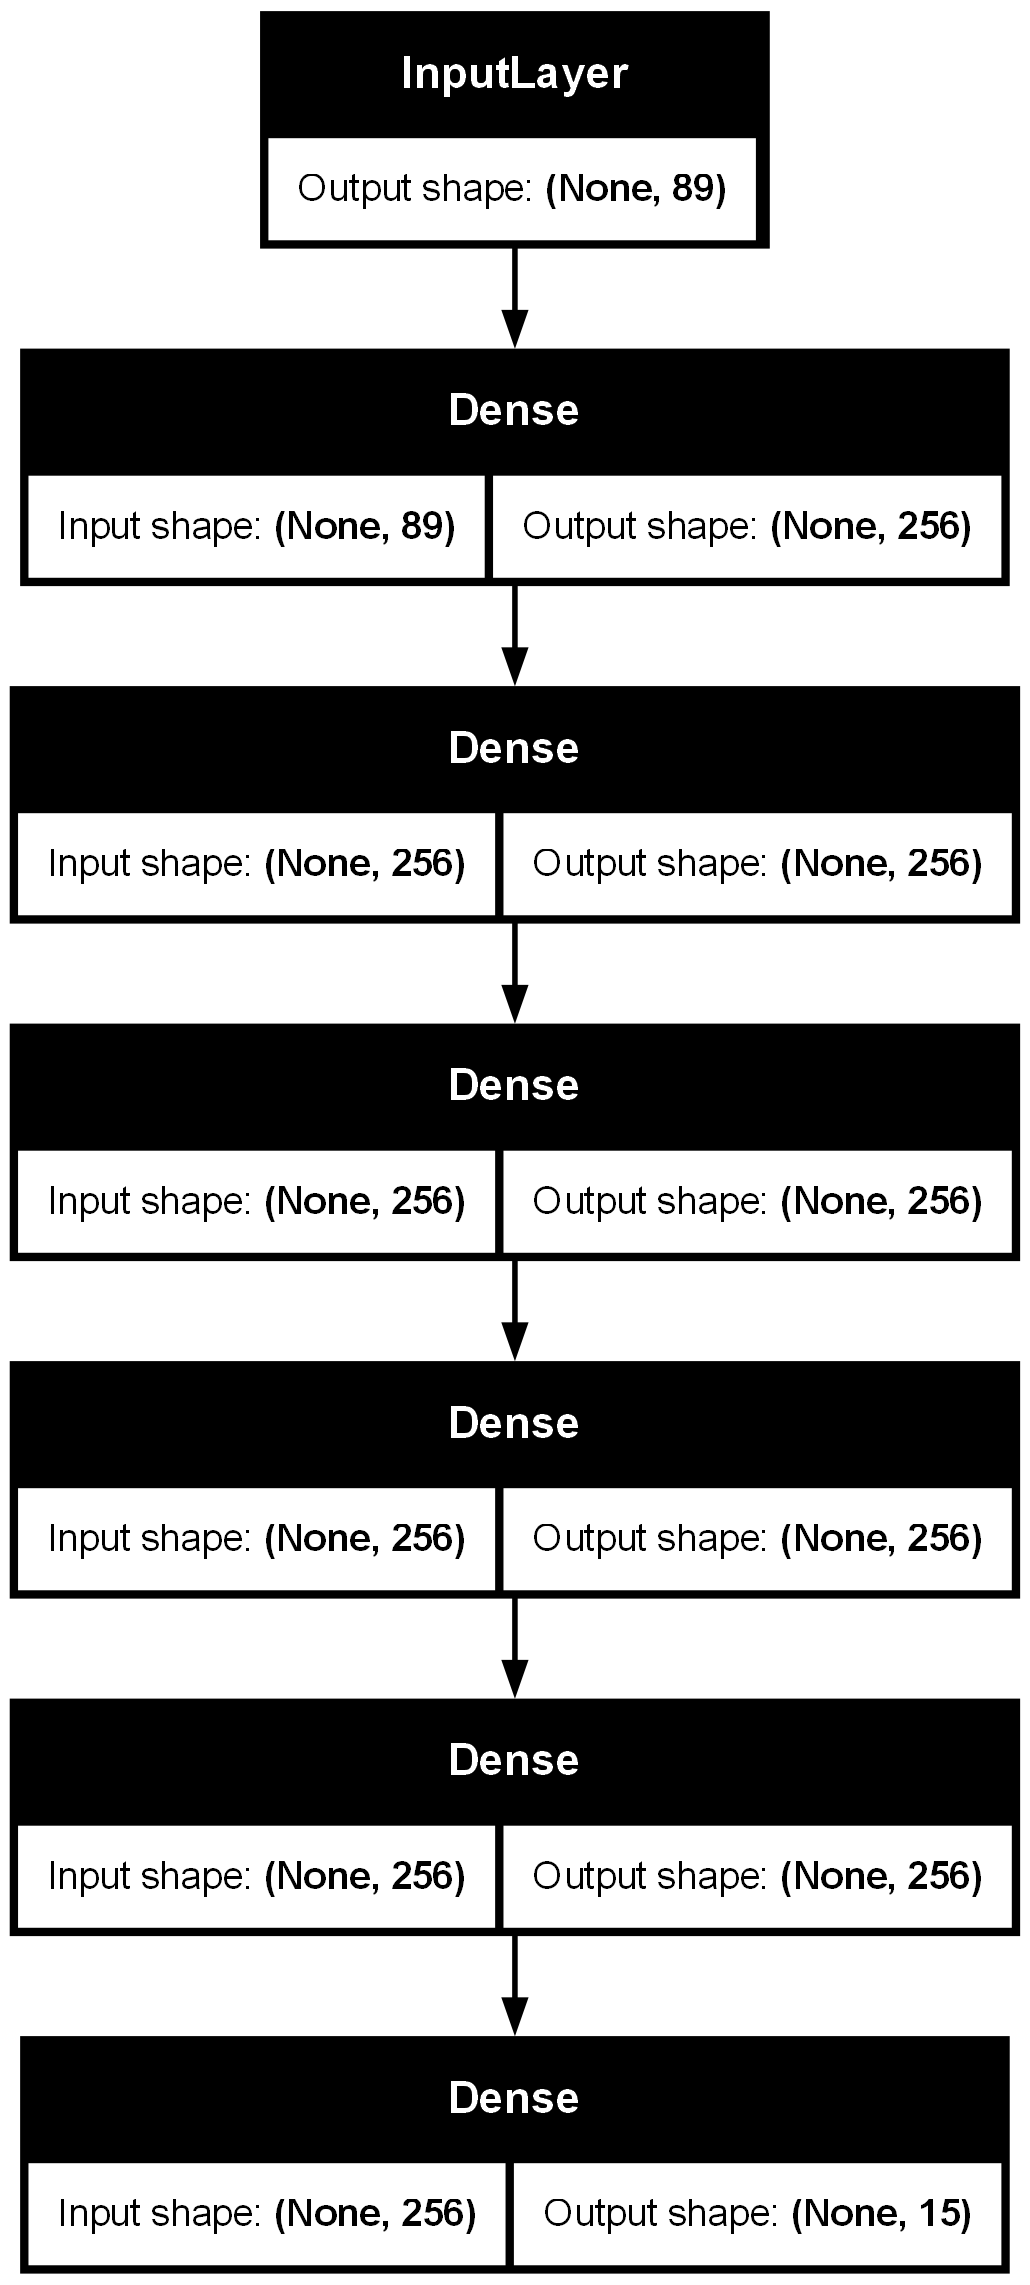

In [52]:
keras.utils.plot_model(model, show_shapes=True)

In [64]:

# from tensorflow.keras import layers, models

# model = models.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(input_shape,)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(output_shape, activation='softmax')
# ])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

history_unreg = model.fit(
    X_train_std, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_std, y_val),
    verbose=1
)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1912 - loss: 2.6674 - val_accuracy: 0.1975 - val_loss: 2.5645
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2005 - loss: 2.5440 - val_accuracy: 0.1975 - val_loss: 2.4949
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2005 - loss: 2.4852 - val_accuracy: 0.1975 - val_loss: 2.4623
Epoch 4/50
153/435 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2072 - loss: 2.4559

KeyboardInterrupt: 

In [68]:
X_train

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,nationality_id,preferred_foot,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,goalkeeping
806,78,78,14500000.0,48000.0,28,185,71,14,1,3,3,2,82.0,78.0,68.0,73.0,42.0,77.0,59,82,75,73,69,70,68,59,63,78,75,87,67,80,66,80,68,89,76,69,65,47,83,74,74,77.0,50,27,20,9,7,11,6,16,78,78,78,75,77,77,77,75,75,75,75,75,71,71,71,75,60,60,60,60,60,58,54,54,54,58,17,1,0,0,0,0,0,0,0,0,9.8
5932,69,69,1200000.0,500.0,31,169,61,52,0,4,4,1,83.0,63.0,67.0,70.0,46.0,64.0,65,55,52,70,62,72,69,70,60,62,83,83,83,68,81,73,74,73,63,68,55,58,62,68,69,71.0,58,31,27,8,6,7,9,7,65,65,65,68,67,67,67,68,68,68,68,68,64,64,64,68,60,58,58,58,60,57,52,52,52,57,14,0,1,0,0,0,0,0,0,0,7.4
4998,70,70,1600000.0,750.0,28,183,82,46,0,3,3,1,68.0,64.0,67.0,71.0,66.0,73.0,62,60,60,70,62,68,64,58,70,71,66,70,76,72,78,70,71,79,71,69,70,70,66,69,47,73.0,68,64,62,10,7,11,10,11,67,67,67,68,68,68,68,68,69,69,69,68,70,70,70,68,68,69,69,69,68,68,67,67,67,68,16,0,0,0,0,0,0,0,0,1,9.8
11165,64,70,950000.0,2000.0,22,182,69,167,0,4,3,1,83.0,58.0,54.0,67.0,20.0,53.0,54,58,51,56,56,69,62,45,41,59,83,83,84,62,67,61,55,61,54,53,39,13,64,58,58,61.0,26,11,11,6,7,13,8,13,61,61,61,64,63,63,63,64,62,62,62,62,52,52,52,62,44,38,38,38,44,41,33,33,33,41,15,0,1,0,0,0,0,0,0,0,9.4
13736,62,63,375000.0,2000.0,28,191,78,14,0,2,2,1,57.0,51.0,59.0,59.0,60.0,71.0,54,48,60,62,47,60,55,52,62,63,57,57,46,60,53,58,63,66,80,52,57,61,57,59,52,62.0,61,60,59,16,9,7,9,12,58,58,58,57,58,58,58,57,59,59,59,59,61,61,61,59,60,62,62,62,60,60,62,62,62,60,17,0,0,0,0,0,1,0,0,0,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,74,74,3700000.0,33000.0,29,181,83,21,1,2,3,2,85.0,46.0,65.0,67.0,70.0,80.0,70,39,60,66,34,67,59,42,63,64,82,87,67,73,73,65,65,79,82,36,78,71,70,67,56,68.0,72,71,73,13,9,15,7,14,62,62,62,66,65,65,65,66,65,65,65,68,66,66,66,68,72,70,70,70,72,72,72,72,72,72,18,0,0,0,0,0,0,0,0,1,11.6
9015,66,67,1000000.0,5000.0,26,180,73,3,0,4,3,1,79.0,57.0,61.0,68.0,42.0,64.0,62,55,50,62,54,67,60,50,58,67,81,77,74,55,76,62,56,65,64,55,65,42,65,65,62,66.0,42,40,38,14,16,12,13,16,61,61,61,65,64,64,64,65,64,64,64,65,60,60,60,65,56,54,54,54,56,54,50,50,50,54,19,0,1,0,0,0,0,0,0,0,14.2
9702,65,75,1500000.0,1000.0,21,181,76,39,1,2,2,1,73.0,51.0,63.0,59.0,59.0,71.0,65,48,54,65,27,55,62,61,62,59,72,74,70,62,74,60,68,75,68,50,74,58,59,61,62,62.0,60,61,58,10,7,12,8,8,58,58,58,60,59,59,59,60,60,60,60,62,61,61,61,62,63,63,63,63,63,63,62,62,62,63,14,0,0,0,0,0,0,1,0,0,9.0
12429,63,70,925000.0,550.0,21,179,72,115,0,3,2,1,73.0,34.0,52.0,50.0,60.0,61.0,52,33,42,59,38,50,41,39,56,42,72,73,61,65,62,32,63,71,55,35,65,62,44,44,39,51.0,61,63,65,7,12,9,7,6,46,46,46,51,48,48,48,51,50,50,50,54,5

In [65]:
X_train

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,nationality_id,preferred_foot,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,goalkeeping
806,78,78,14500000.0,48000.0,28,185,71,14,1,3,3,2,82.0,78.0,68.0,73.0,42.0,77.0,59,82,75,73,69,70,68,59,63,78,75,87,67,80,66,80,68,89,76,69,65,47,83,74,74,77.0,50,27,20,9,7,11,6,16,78,78,78,75,77,77,77,75,75,75,75,75,71,71,71,75,60,60,60,60,60,58,54,54,54,58,17,1,0,0,0,0,0,0,0,0,9.8
5932,69,69,1200000.0,500.0,31,169,61,52,0,4,4,1,83.0,63.0,67.0,70.0,46.0,64.0,65,55,52,70,62,72,69,70,60,62,83,83,83,68,81,73,74,73,63,68,55,58,62,68,69,71.0,58,31,27,8,6,7,9,7,65,65,65,68,67,67,67,68,68,68,68,68,64,64,64,68,60,58,58,58,60,57,52,52,52,57,14,0,1,0,0,0,0,0,0,0,7.4
4998,70,70,1600000.0,750.0,28,183,82,46,0,3,3,1,68.0,64.0,67.0,71.0,66.0,73.0,62,60,60,70,62,68,64,58,70,71,66,70,76,72,78,70,71,79,71,69,70,70,66,69,47,73.0,68,64,62,10,7,11,10,11,67,67,67,68,68,68,68,68,69,69,69,68,70,70,70,68,68,69,69,69,68,68,67,67,67,68,16,0,0,0,0,0,0,0,0,1,9.8
11165,64,70,950000.0,2000.0,22,182,69,167,0,4,3,1,83.0,58.0,54.0,67.0,20.0,53.0,54,58,51,56,56,69,62,45,41,59,83,83,84,62,67,61,55,61,54,53,39,13,64,58,58,61.0,26,11,11,6,7,13,8,13,61,61,61,64,63,63,63,64,62,62,62,62,52,52,52,62,44,38,38,38,44,41,33,33,33,41,15,0,1,0,0,0,0,0,0,0,9.4
13736,62,63,375000.0,2000.0,28,191,78,14,0,2,2,1,57.0,51.0,59.0,59.0,60.0,71.0,54,48,60,62,47,60,55,52,62,63,57,57,46,60,53,58,63,66,80,52,57,61,57,59,52,62.0,61,60,59,16,9,7,9,12,58,58,58,57,58,58,58,57,59,59,59,59,61,61,61,59,60,62,62,62,60,60,62,62,62,60,17,0,0,0,0,0,1,0,0,0,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,74,74,3700000.0,33000.0,29,181,83,21,1,2,3,2,85.0,46.0,65.0,67.0,70.0,80.0,70,39,60,66,34,67,59,42,63,64,82,87,67,73,73,65,65,79,82,36,78,71,70,67,56,68.0,72,71,73,13,9,15,7,14,62,62,62,66,65,65,65,66,65,65,65,68,66,66,66,68,72,70,70,70,72,72,72,72,72,72,18,0,0,0,0,0,0,0,0,1,11.6
9015,66,67,1000000.0,5000.0,26,180,73,3,0,4,3,1,79.0,57.0,61.0,68.0,42.0,64.0,62,55,50,62,54,67,60,50,58,67,81,77,74,55,76,62,56,65,64,55,65,42,65,65,62,66.0,42,40,38,14,16,12,13,16,61,61,61,65,64,64,64,65,64,64,64,65,60,60,60,65,56,54,54,54,56,54,50,50,50,54,19,0,1,0,0,0,0,0,0,0,14.2
9702,65,75,1500000.0,1000.0,21,181,76,39,1,2,2,1,73.0,51.0,63.0,59.0,59.0,71.0,65,48,54,65,27,55,62,61,62,59,72,74,70,62,74,60,68,75,68,50,74,58,59,61,62,62.0,60,61,58,10,7,12,8,8,58,58,58,60,59,59,59,60,60,60,60,62,61,61,61,62,63,63,63,63,63,63,62,62,62,63,14,0,0,0,0,0,0,1,0,0,9.0
12429,63,70,925000.0,550.0,21,179,72,115,0,3,2,1,73.0,34.0,52.0,50.0,60.0,61.0,52,33,42,59,38,50,41,39,56,42,72,73,61,65,62,32,63,71,55,35,65,62,44,44,39,51.0,61,63,65,7,12,9,7,6,46,46,46,51,48,48,48,51,50,50,50,54,5

In [67]:
y_train.value_counts()

player_position_CAM  player_position_CB  player_position_CDM  player_position_CF  player_position_CM  player_position_GK  player_position_LB  player_position_LM  player_position_LW  player_position_LWB  player_position_RB  player_position_RM  player_position_RW  player_position_RWB  player_position_ST
0                    1                   0                    0                   0                   0                   0                   0                   0                   0                    0                   0                   0                   0                    0                     2744
                     0                   0                    0                   0                   0                   0                   0                   0                   0                    0                   0                   0                   0                    1                     1722
                                                                           

In [53]:
print(y_train.sum(axis=0))


player_position_CAM    1171
player_position_CB     2744
player_position_CDM    1259
player_position_CF      115
player_position_CM     1201
player_position_GK     1549
player_position_LB      887
player_position_LM      923
player_position_LW      584
player_position_LWB     188
player_position_RB      662
player_position_RM      456
player_position_RW      296
player_position_RWB     142
player_position_ST     1722
dtype: int64


In [54]:
print(y_train.head())


       player_position_CAM  player_position_CB  player_position_CDM  \
806                      0                   0                    0   
5932                     0                   0                    0   
4998                     0                   0                    0   
11165                    0                   0                    0   
13736                    0                   1                    0   

       player_position_CF  player_position_CM  player_position_GK  \
806                     0                   0                   0   
5932                    0                   0                   0   
4998                    0                   1                   0   
11165                   0                   0                   0   
13736                   0                   0                   0   

       player_position_LB  player_position_LM  player_position_LW  \
806                     0                   0                   0   
5932                

In [58]:
y_train.value_counts()

player_position_CAM  player_position_CB  player_position_CDM  player_position_CF  player_position_CM  player_position_GK  player_position_LB  player_position_LM  player_position_LW  player_position_LWB  player_position_RB  player_position_RM  player_position_RW  player_position_RWB  player_position_ST
0                    1                   0                    0                   0                   0                   0                   0                   0                   0                    0                   0                   0                   0                    0                     2744
                     0                   0                    0                   0                   0                   0                   0                   0                   0                    0                   0                   0                   0                    1                     1722
                                                                           

In [54]:
X_val_std

array([[-0.26325484, -0.64153833, -0.2893616 , ..., -0.20905391,
        -1.04046104, -0.49766466],
       [ 0.61881652,  0.33382168, -0.13795662, ..., -0.20905391,
        -1.04046104, -0.20440468],
       [-0.41026673,  0.49638169, -0.24562238, ..., -0.20905391,
        -1.04046104, -0.47420386],
       ...,
       [ 0.76582841,  1.14662169,  0.13120778, ..., -0.20905391,
        -1.04046104, -0.47420386],
       [ 0.61881652, -0.15385832, -0.34319448, ..., -0.20905391,
         0.96111239, -0.38036066],
       [-0.70429052, -0.64153833, -0.31627804, ..., -0.20905391,
        -1.04046104, -0.34516947]])

In [55]:
y_val

,player_position_CAM,player_position_CB,player_position_CDM,player_position_CF,player_position_CM,player_position_GK,player_position_LB,player_position_LM,player_position_LW,player_position_LWB,player_position_RB,player_position_RM,player_position_RW,player_position_RWB,player_position_ST
11350,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4624,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12122,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8165,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12349,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
15121,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3691,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4775,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
print(y_train.value_counts())


player_position_CAM  player_position_CB  player_position_CDM  player_position_CF  player_position_CM  player_position_GK  player_position_LB  player_position_LM  player_position_LW  player_position_LWB  player_position_RB  player_position_RM  player_position_RW  player_position_RWB  player_position_ST
0                    1                   0                    0                   0                   0                   0                   0                   0                   0                    0                   0                   0                   0                    0                     2744
                     0                   0                    0                   0                   0                   0                   0                   0                   0                    0                   0                   0                   0                    1                     1722
                                                                           

In [53]:
test_scores_unreg = model.evaluate(X_test_std, y_test, verbose=0)
print('Unregularized Model Scores: ')
print("Test loss:", test_scores_unreg[0])
print("Test accuracy:", test_scores_unreg[1])

Unregularized Model Scores: 
Test loss: 2.468592405319214
Test accuracy: 0.19771863520145416


In [49]:
# Here we plot the training and validation loss and accuracy
def plot_losses(history, title):
    fig, ax = plt.subplots(1,2,figsize = (16,4))
    ax[0].plot(history.history['loss'],color='#EFAEA4',label = 'Training Loss')
    ax[0].plot(history.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
    ax[1].plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
    ax[1].plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Accuracy');
    fig.suptitle(title, fontsize = 24)

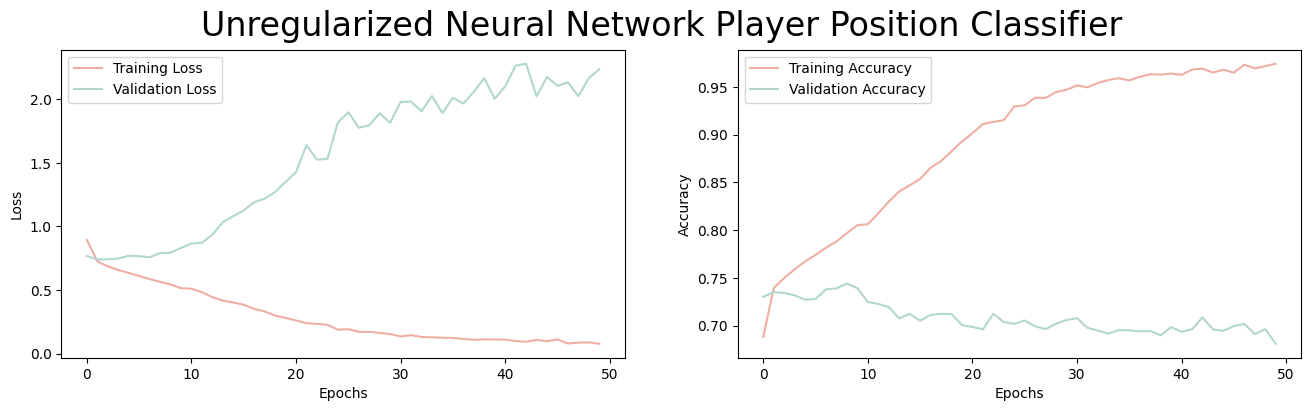

In [50]:
plot_losses(history_unreg, 'Unregularized Neural Network Player Position Classifier')

### 3.2 Regularized Model using Early Stopping

In [51]:
inputs = keras.Input(shape=(input_shape,))

hidden = layers.Dense(256, activation="relu")(inputs)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)

outputs = layers.Dense(output_shape, activation="softmax", name="output_layer")(hidden)

model_early = keras.Model(inputs=inputs, outputs=outputs, name="fifa_position_classifier_early_stopping")

In [52]:
model_early.summary()

Model: "fifa_position_classifier_early_stopping"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 95)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,599 (1.11 MB)

 Trainable params: 291,599 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
keras.utils.plot_model(model_early, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [54]:
model_early.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_early = model_early.fit(X_train_std, y_train, batch_size=32, epochs=50, validation_data=(X_val_std, y_val), verbose=1, callbacks=[callback])

Epoch 1/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6210 - loss: 1.1262 - val_accuracy: 0.7218 - val_loss: 0.7921
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7315 - loss: 0.7527 - val_accuracy: 0.7407 - val_loss: 0.7320
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7428 - loss: 0.7108 - val_accuracy: 0.7250 - val_loss: 0.7471
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7490 - loss: 0.6844 - val_accuracy: 0.7288 - val_loss: 0.7479
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7595 - loss: 0.6556 - val_accuracy: 0.7211 - val_loss: 0.7610
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7601 - loss: 0.6383 - val_accuracy: 0.7301 - val_loss: 0.7560
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7709 - loss: 0.6051 - val_accuracy: 0.7268 - val_loss: 0.7656
Epoch 8/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7810 - loss: 0.5785 - val_accuracy: 0.

**Notice that the training stops early since we are doing early stopping with patience=5.**

In [55]:
test_scores_early = model_early.evaluate(X_test_std, y_test, verbose=0)
print('Early Stopping Model Scores: ')
print("Test loss:", test_scores_early[0])
print("Test accuracy:", test_scores_early[1])

Early Stopping Model Scores: 
Test loss: 0.7387384176254272
Test accuracy: 0.7177700400352478


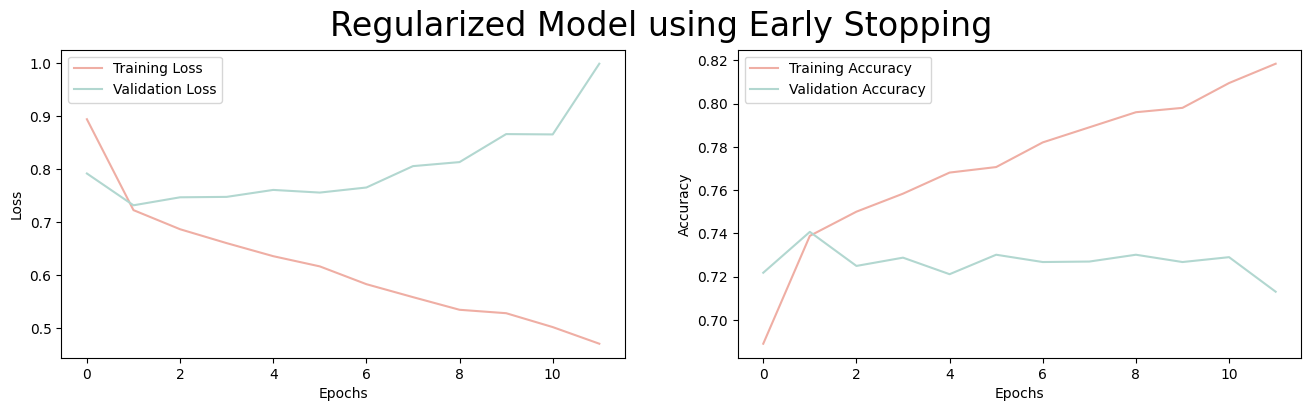

In [56]:
plot_losses(history_early, 'Regularized Model using Early Stopping')

- Model **stops training early** when it finds the lowest validation loss.
- **Patience is set to 10** so it trains for 10 epochs more than the epoch at which lowest validation loss was found.

### 3.3 Regularized Model using Dropout

In [57]:
inputs = keras.Input(shape=(input_shape,))

hidden = layers.Dense(256, activation="relu")(inputs)
hidden = layers.Dropout(rate=0.2)(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dropout(rate=0.2)(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dropout(rate=0.2)(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dropout(rate=0.2)(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dropout(rate=0.2)(hidden)

outputs = layers.Dense(output_shape, activation="softmax", name="output_layer")(hidden)

model_dropout = keras.Model(inputs=inputs, outputs=outputs, name="fifa_position_classifier_dropout")

In [58]:
model_dropout.summary()

Model: "fifa_position_classifier_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 95)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,599 (1.11 MB)

 Trainable params: 291,599 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
keras.utils.plot_model(model_dropout, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [60]:
model_dropout.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

history_dropout = model_dropout.fit(X_train_std, y_train, batch_size=32, epochs=50, validation_data=(X_val_std, y_val), verbose=1)

Epoch 1/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5622 - loss: 1.3203 - val_accuracy: 0.7198 - val_loss: 0.7863
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7032 - loss: 0.8377 - val_accuracy: 0.7353 - val_loss: 0.7451
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7185 - loss: 0.7999 - val_accuracy: 0.7367 - val_loss: 0.7245
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7266 - loss: 0.7723 - val_accuracy: 0.7477 - val_loss: 0.7143
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7321 - loss: 0.7447 - val_accuracy: 0.7457 - val_loss: 0.7151
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7374 - loss: 0.7248 - val_accuracy: 0.7394 - val_loss: 0.7141
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7428 - loss: 0.7185 - val_accuracy: 0.7522 - val_loss: 0.6991
Epoch 8/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7423 - loss: 0.7048 - val_accuracy: 0.

In [61]:
test_scores_dropout = model_dropout.evaluate(X_test_std, y_test, verbose=0)
print('Dropout Model Scores: ')
print("Test loss:", test_scores_dropout[0])
print("Test accuracy:", test_scores_dropout[1])

Dropout Model Scores: 
Test loss: 0.8700745701789856
Test accuracy: 0.7526132464408875


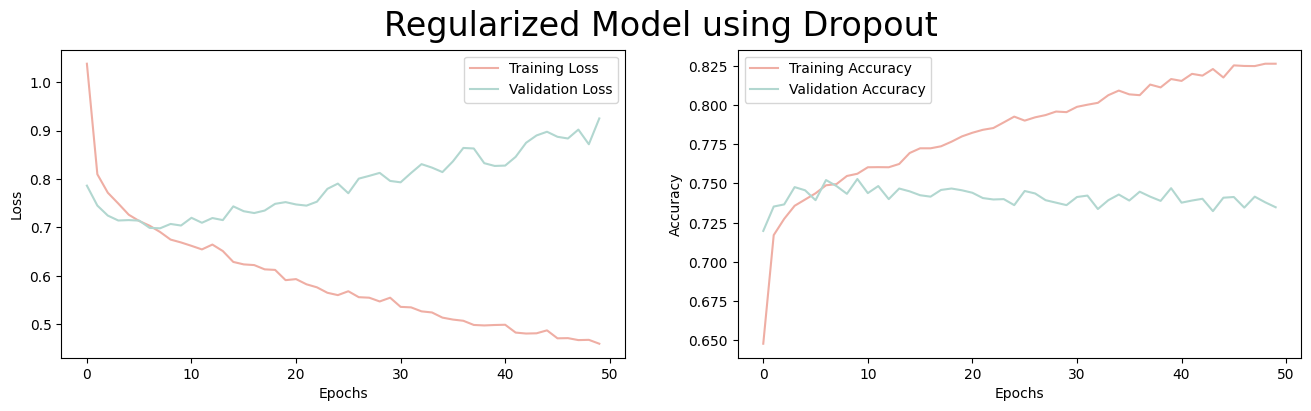

In [62]:
plot_losses(history_dropout, 'Regularized Model using Dropout')

- We see that the after some epochs the training loss starts decreasing rapidly.
- However, the validation loss does not increase too much. It increases relatively lesser than the unregulaized model

### 3.4 Regularized Model using both Dropout and Early Stopping

In [63]:
inputs = keras.Input(shape=(input_shape,))

hidden = layers.Dense(256, activation="relu")(inputs)
hidden = layers.Dropout(rate=0.2)(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dropout(rate=0.2)(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dropout(rate=0.2)(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dropout(rate=0.2)(hidden)
hidden = layers.Dense(256, activation="relu")(hidden)
hidden = layers.Dropout(rate=0.2)(hidden)

outputs = layers.Dense(output_shape, activation="softmax", name="output_layer")(hidden)

model_hybrid = keras.Model(inputs=inputs, outputs=outputs, name="fifa_position_classifier_hybrid")

In [64]:
model_hybrid.summary()

Model: "fifa_position_classifier_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 95)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,599 (1.11 MB)

 Trainable params: 291,599 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
keras.utils.plot_model(model_hybrid, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [66]:
model_hybrid.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_hybrid = model_hybrid.fit(X_train_std, y_train, batch_size=32, epochs=50, validation_data=(X_val_std, y_val), verbose=1, callbacks=[callback])

Epoch 1/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5528 - loss: 1.3241 - val_accuracy: 0.7223 - val_loss: 0.7975
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6992 - loss: 0.8537 - val_accuracy: 0.7349 - val_loss: 0.7434
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7228 - loss: 0.7926 - val_accuracy: 0.7403 - val_loss: 0.7296
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7275 - loss: 0.7611 - val_accuracy: 0.7367 - val_loss: 0.7205
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7322 - loss: 0.7485 - val_accuracy: 0.7425 - val_loss: 0.7146
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7405 - loss: 0.7260 - val_accuracy: 0.7452 - val_loss: 0.7267
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7383 - loss: 0.7158 - val_accuracy: 0.7497 - val_loss: 0.7086
Epoch 8/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7468 - loss: 0.7063 - val_accuracy: 0.

In [67]:
test_scores_hybrid = model_hybrid.evaluate(X_test_std, y_test, verbose=0)
print('Hybrid Model (Dropout & Early Stopping) Scores: ')
print("Test loss:", test_scores_hybrid[0])
print("Test accuracy:", test_scores_hybrid[1])

Hybrid Model (Dropout & Early Stopping) Scores: 
Test loss: 0.6833720803260803
Test accuracy: 0.7282230257987976


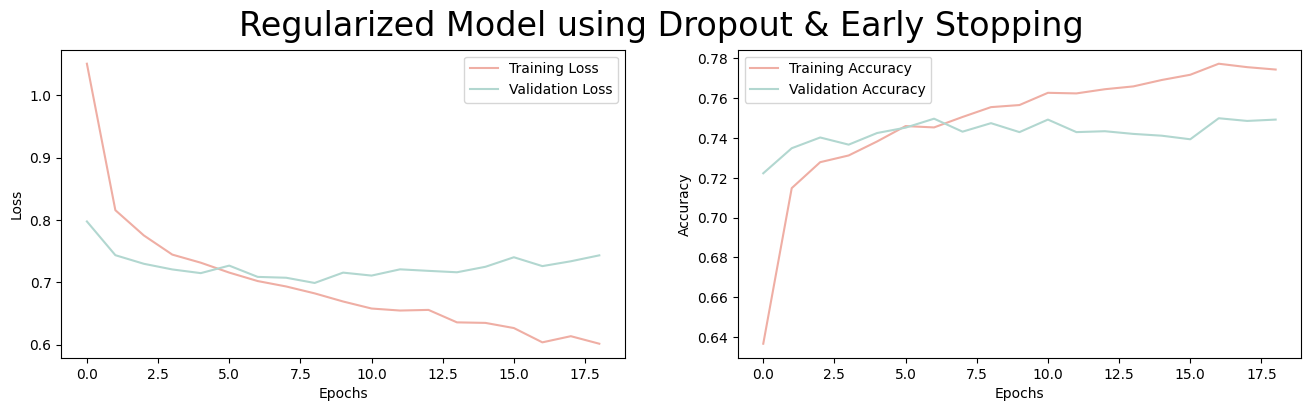

In [68]:
plot_losses(history_hybrid, 'Regularized Model using Dropout & Early Stopping')

- We notice that the training loss doesn't increase as seen in the previous models.
- Since we are using two regularization techniques - Dropout and Early stopping - the model does not overfit
- This is the reason the test accuracy is of 75.96% is the highest

## 4. Can a professional defender become a forward?

In [69]:
response_variables

['player_position_CAM',
 'player_position_CB',
 'player_position_CDM',
 'player_position_CF',
 'player_position_CM',
 'player_position_GK',
 'player_position_LB',
 'player_position_LM',
 'player_position_LW',
 'player_position_LWB',
 'player_position_RB',
 'player_position_RM',
 'player_position_RW',
 'player_position_RWB',
 'player_position_ST']

**Define list of defender positions present in dataset**

In [70]:
defender_positions = ['player_position_CB', 'player_position_LB', 'player_position_LWB',
                      'player_position_RB', 'player_position_RWB']

**Define list of forward positions present in dataset**

In [71]:
forward_positions = ['player_position_CF', 'player_position_ST', 'player_position_LW', 'player_position_RW']

**Get all players from FIFA 23 playing in defender positions**

In [72]:
fifa23_defenders = fifa_23[fifa_23[defender_positions].any(axis=1)]
# Print first 10 defenders with their name and positions
fifa23_defenders[['short_name'] + defender_positions].head(10)

,short_name,player_position_CB,player_position_LB,player_position_LWB,player_position_RB,player_position_RWB
5,Sergio Ramos,1,0,0,0,0
12,D. Godín,1,0,0,0,0
21,G. Chiellini,1,0,0,0,0
24,M. Hummels,1,0,0,0,0
34,Thiago Silva,1,0,0,0,0
38,Marcelo,0,1,0,0,0
42,S. Umtiti,1,0,0,0,0
43,K. Koulibaly,1,0,0,0,0
46,Piqué,1,0,0,0,0
49,J. Vertonghen,1,0,0,0,0


**Find number of defenders in FIFA 23 who became forwards in FIFA 24**

Steps:

- For each defender in FIFA 23, do the following: 
    - Get sofifa id of player
    - Find player in FIFA 24 using sofifa id
    - Check player's position in FIFA 24
    - If position is forward, store the player and increase count
    - If position is not forward, continue to next iteration

In [73]:
# Create lists to store 'sofifa_id' of defenders who became forwards and those who did not and those who are not present in FIFA 24
def_to_fwd = {}
def_not_to_fwd = []
def_not_present = []

# Iterate through all rows of defenders dataframe
for idx, row in fifa23_defenders.iterrows():

    # Flag to check if defender converted to forward
    converted = False    

    # sofifa_id of defender
    sofifa_id = row['sofifa_id']
    
    # Find this player in FIFA 24 dataset
    fifa24_stats = fifa_24[fifa_24['sofifa_id'] == sofifa_id]
    
    # If player not found in FIFA 24 dataset, store sofifa_id and continue to next iteration
    if len(fifa24_stats) == 0:
        def_not_present.append(sofifa_id)
        continue

    # Forward positions data in FIFA 24 for current player
    for col in forward_positions:
        if fifa24_stats[col].all() == 1:
            def_to_fwd[sofifa_id] = col
            converted = True
            break
    
    if not converted:
        def_not_to_fwd.append(sofifa_id)

In [74]:
# Total number of defenders in FIFA 23
num_defenders23 = len(fifa23_defenders)

# Total number of defenders in FIFA 23 who became forwards in FIFA 24
def_to_fwd_count = len(def_to_fwd)

# Total number of defenders in FIFA 23 who did not become forwards in FIFA 24
def_not_to_fwd_count = len(def_not_to_fwd)

# Total number of defenders in FIFA 23 not found in FIFA 24 dataset
def_not_present_count = len(def_not_present)

print(f'Total number of defenders in FIFA 23 (also present in FIFA 24 dataset) = {num_defenders23 - def_not_present_count}')
print(f'Number of defenders in FIFA 23 who became forwards in FIFA 24 = {def_to_fwd_count}')
print(f'Number of defenders in FIFA 23 who did not become forwards in FIFA 24 = {def_not_to_fwd_count}')
print(f'Percentage conversion of defenders to forwards from FIFA 23 to FIFA 24 = {round((def_to_fwd_count/(num_defenders23 - def_not_present_count)) * 100, 2)} %')

Total number of defenders in FIFA 19 (also present in FIFA 20 dataset) = 4387
Number of defenders in FIFA 19 who became forwards in FIFA 20 = 4
Number of defenders in FIFA 19 who did not become forwards in FIFA 20 = 4383
Percentage conversion of defenders to forwards from FIFA 19 to FIFA 20 = 0.09 %


In [75]:
converted_defenders_23 = fifa_23[fifa_23['sofifa_id'].isin(list(def_to_fwd.keys()))]
converted_defenders_24 = fifa_24[fifa_24['sofifa_id'].isin(list(def_to_fwd.keys()))]

not_converted_defenders_23 = fifa_23[fifa_23['sofifa_id'].isin(def_not_to_fwd)]
not_converted_defenders_24 = fifa_24[fifa_24['sofifa_id'].isin(def_not_to_fwd)]

## 5. Results and Discussion

### 5.1 Player position classification task

**Plot the validation & training loss for the four models**

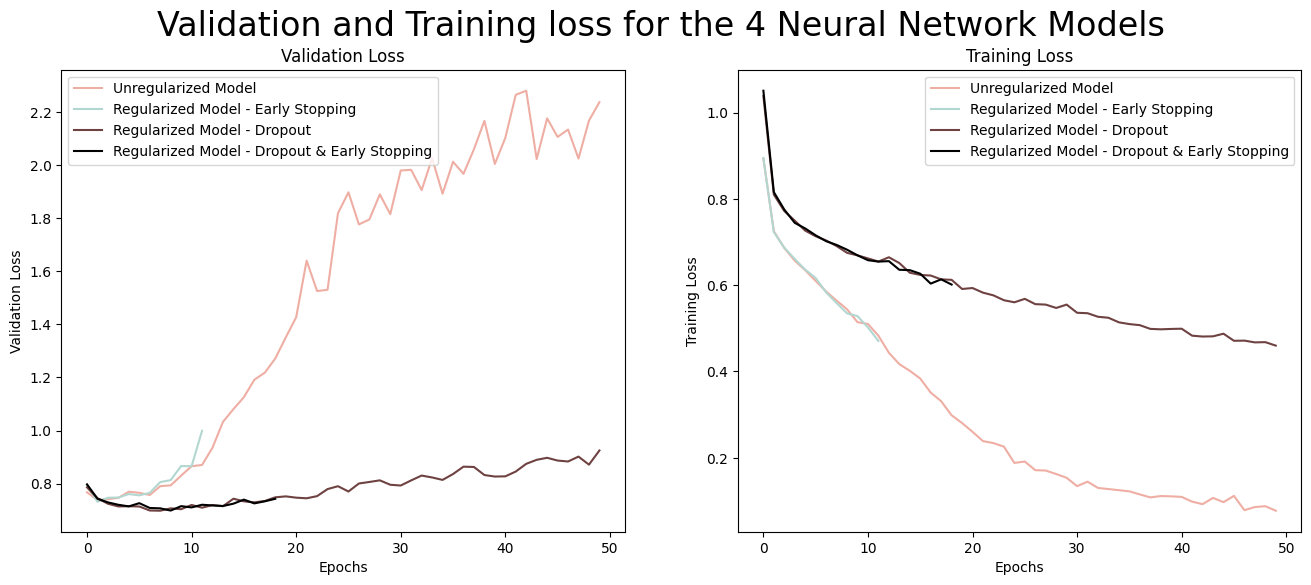

In [76]:
fig, ax = plt.subplots(1,2,figsize = (16,6))

ax[0].plot(history_unreg.history['val_loss'],color='#EFAEA4',label = 'Unregularized Model')
ax[0].plot(history_early.history['val_loss'],color='#B2D7D0',label = 'Regularized Model - Early Stopping')
ax[0].plot(history_dropout.history['val_loss'],color='#6F4242',label = 'Regularized Model - Dropout')
ax[0].plot(history_hybrid.history['val_loss'],color='black',label = 'Regularized Model - Dropout & Early Stopping')

ax[1].plot(history_unreg.history['loss'],color='#EFAEA4',label = 'Unregularized Model')
ax[1].plot(history_early.history['loss'],color='#B2D7D0',label = 'Regularized Model - Early Stopping')
ax[1].plot(history_dropout.history['loss'],color='#6F4242',label = 'Regularized Model - Dropout')
ax[1].plot(history_hybrid.history['loss'],color='black',label = 'Regularized Model - Dropout & Early Stopping')

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')

ax[0].set_ylabel('Validation Loss')
ax[1].set_ylabel('Training Loss')

ax[0].set_title('Validation Loss')
ax[1].set_title('Training Loss')

fig.suptitle('Validation and Training loss for the 4 Neural Network Models', fontsize = 24)
plt.show()

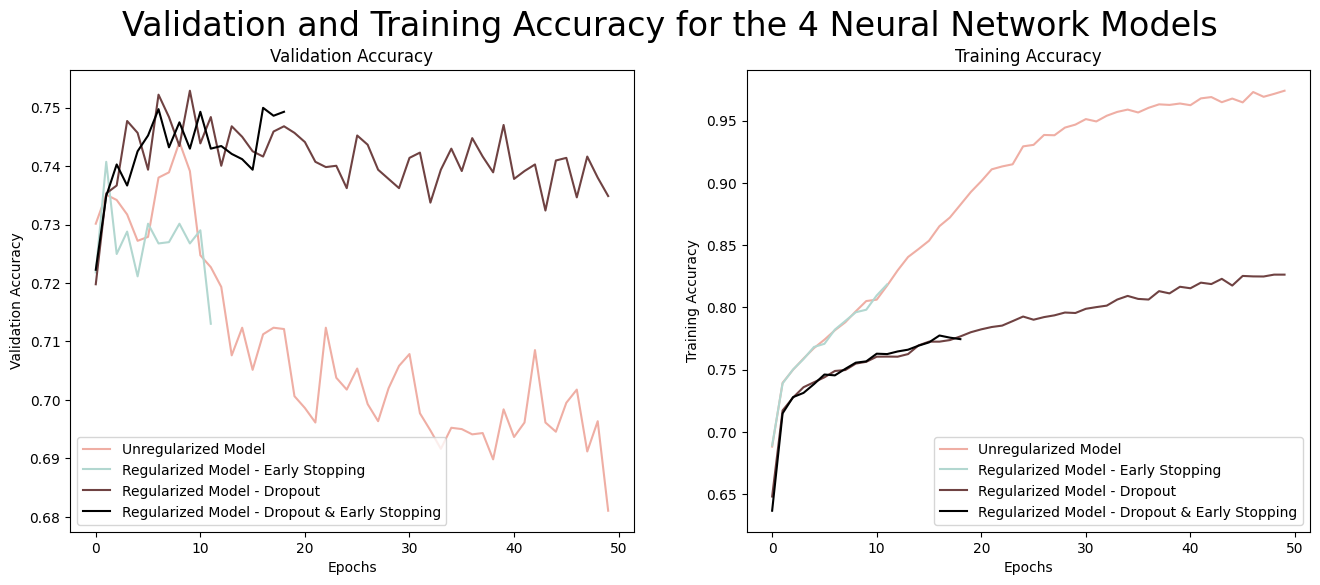

In [77]:
fig, ax = plt.subplots(1,2,figsize = (16,6))

ax[0].plot(history_unreg.history['val_accuracy'],color='#EFAEA4',label = 'Unregularized Model')
ax[0].plot(history_early.history['val_accuracy'],color='#B2D7D0',label = 'Regularized Model - Early Stopping')
ax[0].plot(history_dropout.history['val_accuracy'],color='#6F4242',label = 'Regularized Model - Dropout')
ax[0].plot(history_hybrid.history['val_accuracy'],color='black',label = 'Regularized Model - Dropout & Early Stopping')

ax[1].plot(history_unreg.history['accuracy'],color='#EFAEA4',label = 'Unregularized Model')
ax[1].plot(history_early.history['accuracy'],color='#B2D7D0',label = 'Regularized Model - Early Stopping')
ax[1].plot(history_dropout.history['accuracy'],color='#6F4242',label = 'Regularized Model - Dropout')
ax[1].plot(history_hybrid.history['accuracy'],color='black',label = 'Regularized Model - Dropout & Early Stopping')

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')

ax[0].set_ylabel('Validation Accuracy')
ax[1].set_ylabel('Training Accuracy')

ax[0].set_title('Validation Accuracy')
ax[1].set_title('Training Accuracy')

fig.suptitle('Validation and Training Accuracy for the 4 Neural Network Models', fontsize = 24)
plt.show()

**Observations:**

- We observe that the unregularized model accuracy decreases after some epoch although the training accuracy is increasing
- In comparison, the regularized model do well to not decrease validation accuracy too much as training accuracy increases
- They help in avoiding overfitting


In [78]:
model_comparison = PrettyTable()
model_comparison.field_names = ['Player Position Classifier', 'Test Accuracy', 'Test Loss']
model_comparison.add_row(['Unregularized Model', test_scores_unreg[1], test_scores_unreg[0]])
model_comparison.add_row(['Regularized Model - Early Stopping', test_scores_early[1], test_scores_early[0]])
model_comparison.add_row(['Regularized Model - Dropout', test_scores_dropout[1], test_scores_dropout[0]])
model_comparison.add_row(['Regularized Model - Dropout & Early Stopping', test_scores_hybrid[1], test_scores_hybrid[0]])

In [79]:
print(model_comparison)

+----------------------------------------------+--------------------+--------------------+
|          Player Position Classifier          |   Test Accuracy    |     Test Loss      |
+----------------------------------------------+--------------------+--------------------+
|             Unregularized Model              | 0.700348436832428  | 2.085949659347534  |
|      Regularized Model - Early Stopping      | 0.7177700400352478 | 0.7387384176254272 |
|         Regularized Model - Dropout          | 0.7526132464408875 | 0.8700745701789856 |
| Regularized Model - Dropout & Early Stopping | 0.7282230257987976 | 0.6833720803260803 |
+----------------------------------------------+--------------------+--------------------+


### 5.2 Defender to Forward Conversion Analysis

In [80]:
defender_conversion = PrettyTable()
defender_conversion.field_names = ['Metrics', 'Values']
defender_conversion.add_row(['Total number of defenders in FIFA 2423 Dataset', num_defenders23 - def_not_present_count ])
defender_conversion.add_row(['Defenders who became forward in 2424', def_to_fwd_count ])
defender_conversion.add_row(['Defenders who did not become forward', def_not_to_fwd_count ])
defender_conversion.add_row(['Defender to Forward conversion rate', str(round((def_to_fwd_count/(num_defenders23 - def_not_present_count)) * 100, 2)) + '%' ])
print(defender_conversion)

+------------------------------------------------+--------+
|                    Metrics                     | Values |
+------------------------------------------------+--------+
| Total number of defenders in FIFA 2019 Dataset |  4387  |
|      Defenders who became forward in 2020      |   4    |
|      Defenders who did not become forward      |  4383  |
|      Defender to Forward conversion rate       | 0.09%  |
+------------------------------------------------+--------+


## 6. References

Some data ideas in this notebook were taken from the following kaggle notebooks:

1) https://www.kaggle.com/codebreaker623/fifa-24-sports-analytics

2) https://www.kaggle.com/ashaabrizvi/fifa-24-eda-comparison-using-radar-charts